<a href="https://colab.research.google.com/github/dulhara79/DULHARA_KAUSHALYA_ROP_PREDICTION/blob/main/ROP_predict_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import io

##LOAD DATA

In [2]:
df = pd.read_csv("/content/Data-Set-AI-ML-Assignment-1.csv")
df

,depth,RPM,Flow,WOB,ROP,well
0,25.96,54.947292,2.711315,10.80726,17.310000,A
1,26.27,54.947292,2.711315,10.80726,18.630000,A
2,26.59,61.540000,2.711315,10.80726,5.660000,A
3,26.90,60.230000,2.711315,10.80726,11.670000,A
4,27.24,61.750000,2.711315,10.80726,12.804158,A
...,...,...,...,...,...,...
7306,2295.71,34.910000,2.307170,13.85488,3.290000,A
7307,2296.01,34.780000,2.328370,13.70975,4.120000,A
7308,2296.32,34.720000,2.406610,13.58277,3.850000,A
7309,2296.63,36.490000,2.374020,14.08617,4.490000,A


##EDA

In [3]:
print(f"Columns: {df.columns.to_list()}")
print(df.describe().T)

Columns: ['depth', 'RPM', 'Flow', 'WOB', 'ROP', 'well']
        count         mean         std       min         25%         50%  \
depth  7311.0  1168.864378  654.527243  25.96000  600.545000  1173.99000   
RPM    7311.0    57.169230   21.055557   1.69000   39.920000    53.28000   
Flow   7311.0     2.734865    0.412798   1.66558    2.356950     2.65936   
WOB    7311.0    10.775011    3.745654   0.18141    8.609975    10.80726   
ROP    7311.0    10.352387   10.448501   0.22000    3.480000     5.49000   

               75%         max  
depth  1734.710000  2296.94000  
RPM      74.985000   119.61000  
Flow      3.099950     4.04906  
WOB      13.460320    20.69841  
ROP      12.804158    47.40000  


In [4]:
# check what are the unique values in the categorical column
print("Unique wells:", df['well'].unique() )

Unique wells: ['A']


In [5]:
# Explore the data types of each columns
print(f"Data Types:\n{df.dtypes}")

Data Types:
depth    float64
RPM      float64
Flow     float64
WOB      float64
ROP      float64
well      object
dtype: object


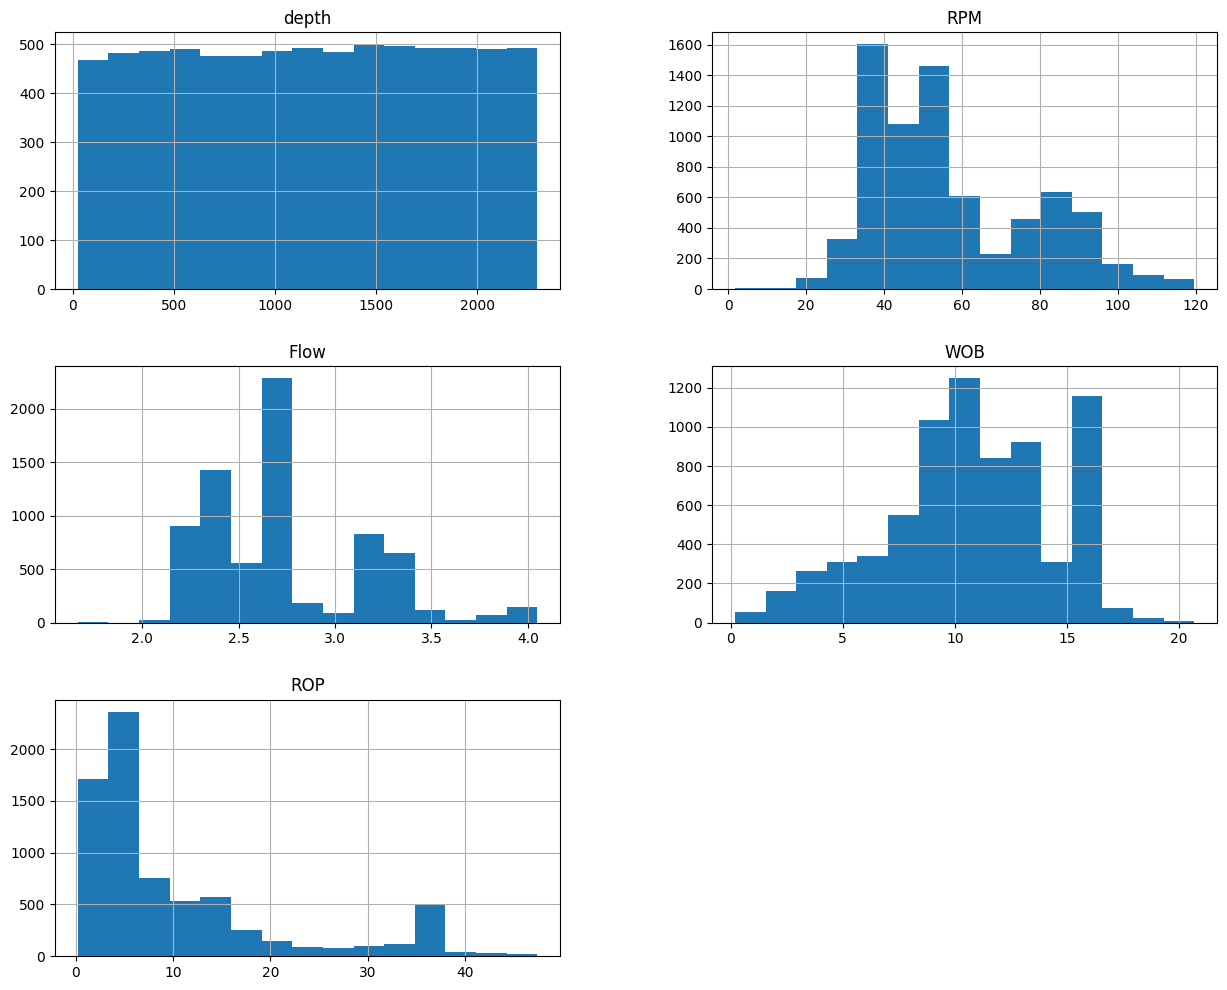

In [6]:
# check feature distribution of the dataset
df.hist(figsize=(15, 12), bins=15)
plt.title("Features Distribution")
plt.show()

<Figure size 1200x960 with 0 Axes>

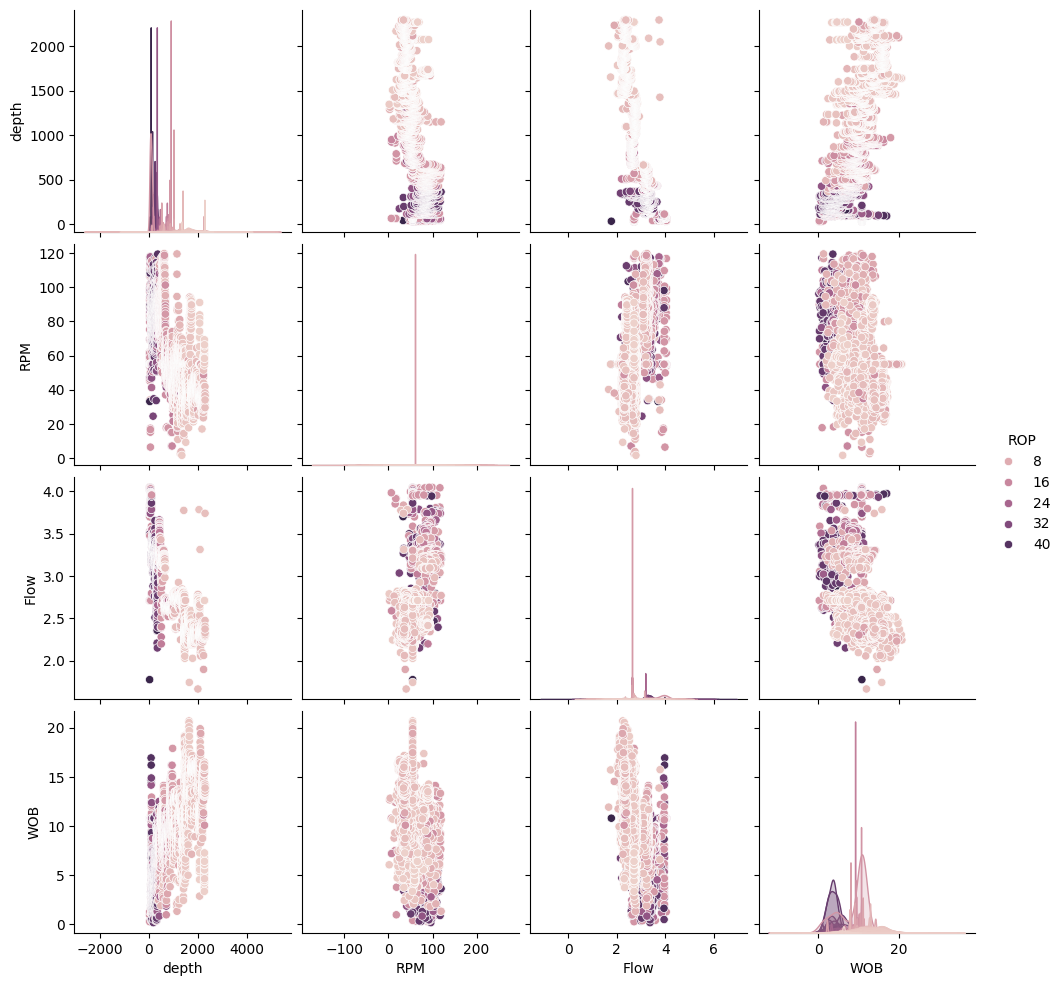

In [7]:
# check relationship between each variable
plt.figure(figsize=(15, 12), dpi=80)
sns.pairplot(df.loc[:, ["depth", "RPM", "Flow", "WOB", "ROP"]],
             kind="scatter", hue="ROP")
plt.show()

In [8]:
# explore the correlationship
corr_matrix = df.drop('well', axis=1).corr()
print(f"Correlation matrix:{corr_matrix}")

Correlation matrix:          depth       RPM      Flow       WOB       ROP
depth  1.000000 -0.680122 -0.840765  0.709194 -0.732284
RPM   -0.680122  1.000000  0.656805 -0.524711  0.535336
Flow  -0.840765  0.656805  1.000000 -0.624400  0.650666
WOB    0.709194 -0.524711 -0.624400  1.000000 -0.631357
ROP   -0.732284  0.535336  0.650666 -0.631357  1.000000


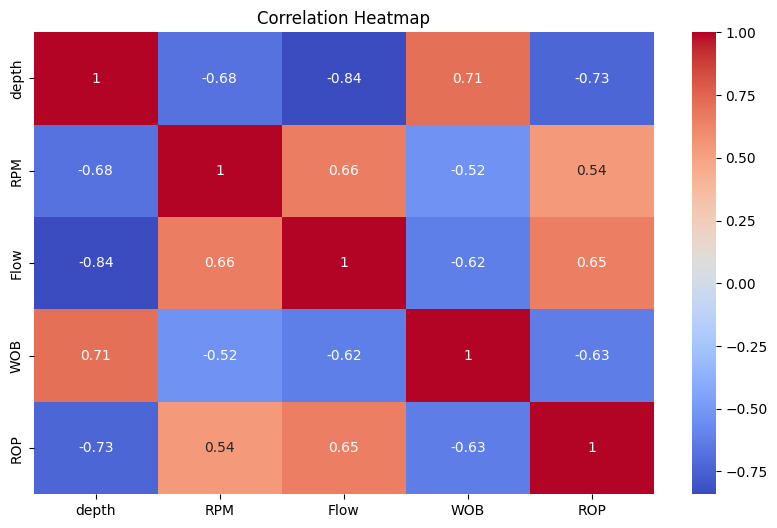

In [9]:
# plot the correlationship using heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

##PRE-PROCESSING & FEATURE ENGINEERING

In [10]:
# copy original data set to new dataset called "df_process"
df_process = df.copy()

'well' column has only 'A' so this column has not predictive power. Keep that column will increase model complexity.

In [11]:
# Drop non-predictive columns
if 'well' in df_process.columns:
    df_process = df_process.drop("well", axis=1)

In [12]:
# check null values
print(f"Null values: {df_process.isnull().sum()}")

Null values: depth    0
RPM      0
Flow     0
WOB      0
ROP      0
dtype: int64


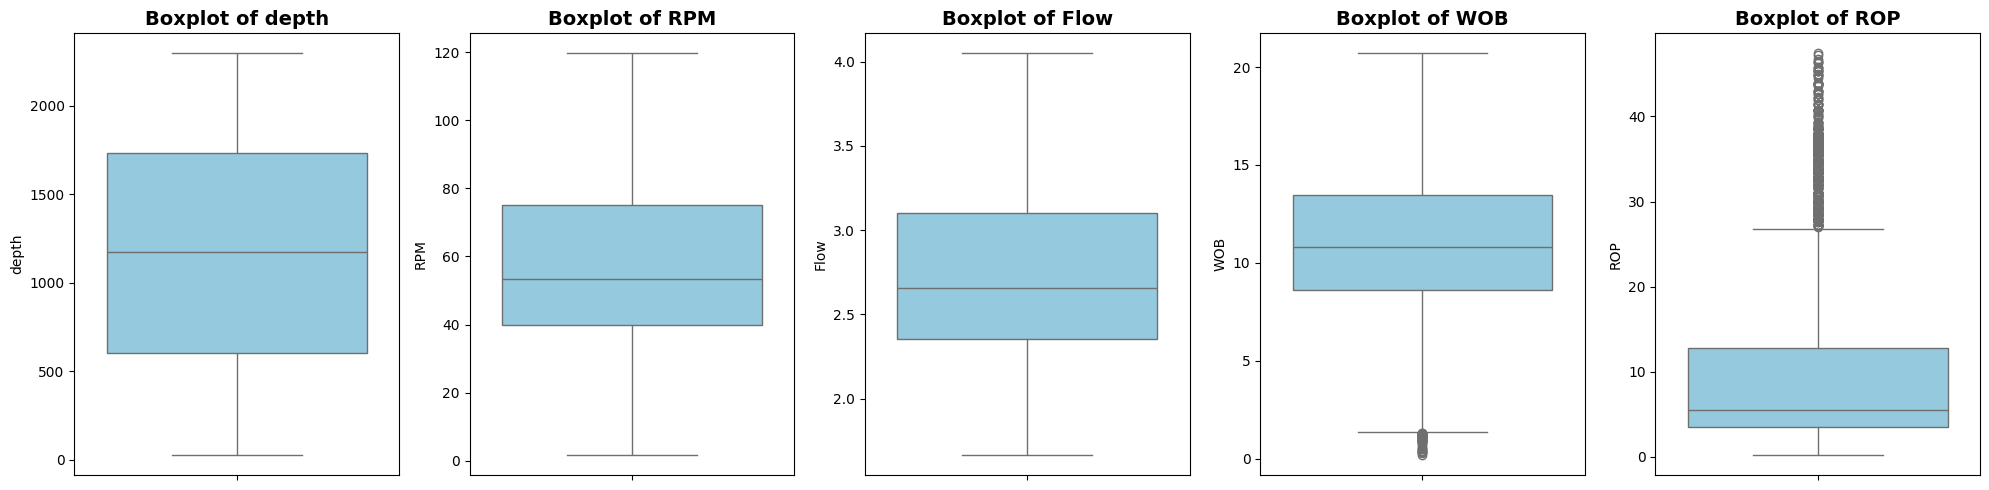

In [13]:
# check outliers
columns = ["depth" ,"RPM", "Flow", "WOB", "ROP"]

fig, axes = plt.subplots(1, len(columns), figsize=(20, 5))

for i, col in enumerate(columns):
  sns.boxplot(y=df_process[col], ax=axes[i], color="skyblue")
  axes[i].set_title(f'Boxplot of {col}', fontsize=14, fontweight='bold')
  axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()

I did not remove the outliers because, Outliers in drilling data are usually real physical events, not errors. Removing them would remove important drilling behavior

In [14]:
# check the duplicates and remove them
duplicate_count = df_process.duplicated().sum()
print(f"Duplicates found: {duplicate_count}")
df_process = df_process.drop_duplicates()

Duplicates found: 31


In [15]:
# re index the datasets
df_process = df_process.reset_index(drop=True)
print(f"shape of the dataset (after remove duplicates): {df_process.shape}")

shape of the dataset (after remove duplicates): (7280, 5)


In [16]:
# Smoothing (Savitzky-Golay)
to_smooth = ["RPM", "Flow", "WOB"]
window_size = 5
poly_order = 3
for col in to_smooth:
    if len(df_process) > window_size:
        df_process[col] = savgol_filter(df_process[col], window_length=window_size, polyorder=poly_order)

In [17]:
# copy "df_process" to the new variable
df_featured = df_process.copy()

* Mechanical Power = WOB x RPM: Represents energy delivered to the drill bit.
* Hydraulic Force = Flow x WOB: Represents hydraulic cleaning + force interaction.
* MSE Proxy = (WOB / π) + (120 x RPM): Relates to Mechanical Specific Energy, a measure of drilling efficiency.

In [18]:
# Physics-based Features
df_featured['Mechanical_Power'] = df_featured['RPM'] * df_featured['WOB']
df_featured['Hydraulic_Force'] = df_featured['Flow'] * df_featured['WOB']
df_featured['MSE_Proxy'] = (df_featured['WOB'] / np.pi) + (120 * df_featured['RPM'])

In [19]:
PROCESS_corr_matrix = df_featured.corr()
print(f"Correlation matrix:{corr_matrix}")

Correlation matrix:          depth       RPM      Flow       WOB       ROP
depth  1.000000 -0.680122 -0.840765  0.709194 -0.732284
RPM   -0.680122  1.000000  0.656805 -0.524711  0.535336
Flow  -0.840765  0.656805  1.000000 -0.624400  0.650666
WOB    0.709194 -0.524711 -0.624400  1.000000 -0.631357
ROP   -0.732284  0.535336  0.650666 -0.631357  1.000000


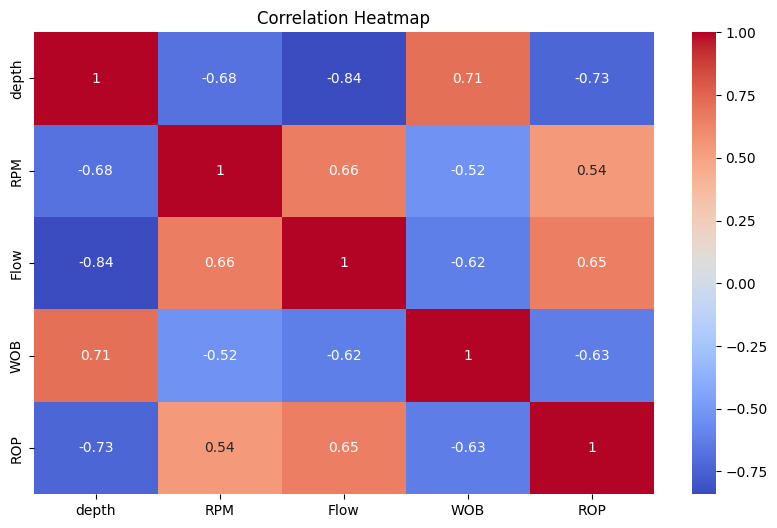

In [20]:
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

###SPLIT THE DATASET

Used an 80/20 random split with shuffle=True.
Shuffling is important because the data is sequential by depth.
Without shuffling, the model would train on shallow data and test on deep data

In [21]:
# Split Data (Shuffle=True is critical)
X = df_featured.drop(columns=['ROP'], axis=1)
y = df_featured['ROP']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

Scale the numerical features using StandardScaler in the sklearn

In [22]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##DEFINE MODELS & BENCHMARK

Linear Regression --> baseline

Random Forest --> handles non-linearity + robust to noise

XGBoost --> high-performance boosting

MLP Neural Network --> non-linear universal approximator

In [23]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    "Neural Network": MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
}

In [24]:
results = [] # store result in the each model
best_score = -np.inf
best_model_name = ""

In [25]:
print("--- Initial Model Benchmark ---")
for name, model in models.items():
    # Train
    model.fit(X_train_scaled, y_train)

    # Evaluate
    preds = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    results.append({"Model": name, "RMSE": rmse, "R2": r2})
    print(f"{name:20} | RMSE: {rmse:.4f} | R2: {r2:.4f}")

    # Track Winner
    if r2 > best_score:
        best_score = r2
        best_model_name = name

print(f"\nBest Initial Model: {best_model_name} (R2: {best_score:.4f})")

--- Initial Model Benchmark ---
Linear Regression    | RMSE: 5.8700 | R2: 0.6950
Random Forest        | RMSE: 3.7506 | R2: 0.8755
XGBoost              | RMSE: 4.1564 | R2: 0.8471
Neural Network       | RMSE: 3.9833 | R2: 0.8596

Best Initial Model: Random Forest (R2: 0.8755)


##HYPERPARAMETER TUNING

In [26]:
# Define Search Spaces for each model type
param_grids = {
    "Random Forest": {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'max_features': ['sqrt', 'log2']
    },
    "XGBoost": {
        'n_estimators': [100, 200, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.7, 0.9]
    },
    "Neural Network": {
        'hidden_layer_sizes': [(64, 32), (100, 50), (128, 64, 32)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate_init': [0.001, 0.01]
    },
    "Linear Regression": {}
}

Used RandomizedSearchCV for the hyperparameter tunning because,
* explores more combinations
* is faster
* good for tree models
* allows random sampling

In [27]:
if best_model_name in param_grids and param_grids[best_model_name]:
    print(f"\n--- Tuning {best_model_name} ---")

    base_model = models[best_model_name]

    search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_grids[best_model_name],
        n_iter=20,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )

    search.fit(X_train_scaled, y_train)
    best_tuned_model = search.best_estimator_

    print(f"Best Parameters: {search.best_params_}")
else:
    print(f"No advanced tuning configuration for {best_model_name}, using default.")
    best_tuned_model = models[best_model_name]



--- Tuning Random Forest ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'n_estimators': 300, 'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': None}


In [28]:
best_rf_model = search.best_estimator_
importances = best_rf_model.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

            Feature  Importance
0             depth    0.473685
2              Flow    0.177807
3               WOB    0.111202
5   Hydraulic_Force    0.079457
1               RPM    0.067942
6         MSE_Proxy    0.058861
4  Mechanical_Power    0.031044


##FINAL EVALUATION & PLOT

In [29]:
final_preds = best_tuned_model.predict(X_test_scaled)
final_rmse = np.sqrt(mean_squared_error(y_test, final_preds))
final_r2 = r2_score(y_test, final_preds)

In [30]:
print("\n" + "="*40)
print(f"FINAL RESULT ({best_model_name})")
print("="*40)
print(f"RMSE: {final_rmse:.4f}")
print(f"R2:   {final_r2:.4f}")
print("="*40)


FINAL RESULT (Random Forest)
RMSE: 3.8121
R2:   0.8714


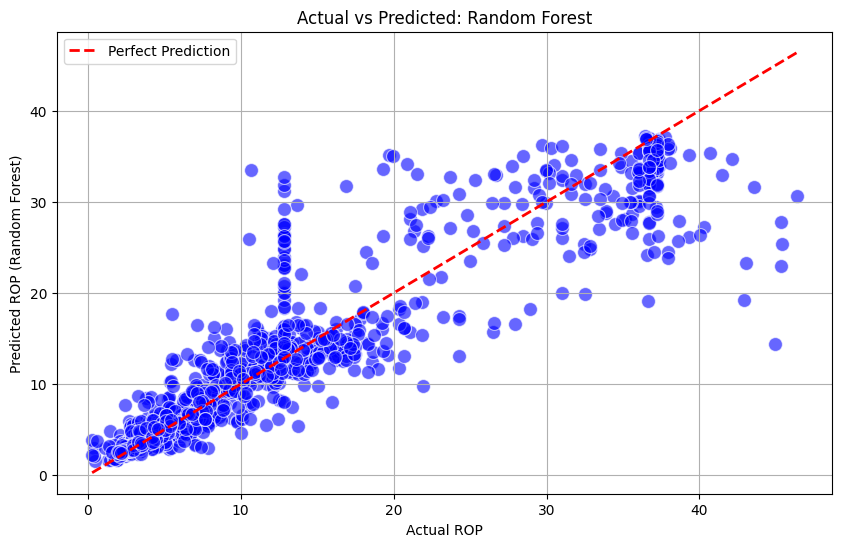

In [31]:
# Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=final_preds, color='blue', alpha=0.6, s=100)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual ROP')
plt.ylabel(f'Predicted ROP ({best_model_name})')
plt.title(f'Actual vs Predicted: {best_model_name}')
plt.legend()
plt.grid(True)
plt.show()

##SAVE THE MODEL

In [32]:
# Save best model
joblib.dump(best_tuned_model, 'best_rop_model_tuned.pkl')
joblib.dump(scaler, 'rop_model_scalar.pkl')
print("All models are saved..!")

All models are saved..!


###References:
* https://stats.stackexchange.com/questions/210061/in-random-forest-what-happens-if-i-add-features-that-are-correlated

* https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter

* https://neptune.ai/blog/random-forest-regression-when-does-it-fail-and-why

* https://www.sinodrills.com/drilling-rate-of-penetration/

* https://www.geeksforgeeks.org/machine-learning/bias-vs-variance-in-machine-learning/

* https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html

* https://medium.com/pythoneers/introduction-to-the-savitzky-golay-filter-a-comprehensive-guide-using-python-b2dd07a8e2ce

* ChatGPT

